# Import libraries :open_file_folder:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import math
import random

import warnings
import json

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, f1_score

import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgbm

# Ignore WARNINGS :warning:

In [2]:
warnings.filterwarnings('ignore')

# Read CSV file :scroll: and some edits :pencil:

In [3]:
df = pd.read_csv("../../csv/alpha2_ultra.csv")
df = df.drop(['address', 'longitude', 'latitude', 'uid', 'center_lat', 'center_lon'], axis=1)
# df['isBigcity'] = df.city.apply(lambda v: True if v in ['Москва', 'Санкт-Петербург'] else False)
df = df[df.price < 32_000_000]
df['total_floors'][15785] = 17
# df.price = np.log1p(df['price'])
# df['predicted_price'] = df.area * df.city_flat_mean_squared_price
# df = df[df.city == "Новосибирск"]
# df = df[df.isBigcity == False]
df = df.drop_duplicates()

df = df.drop(['city_flat_mean_price', 'city_flat_mean_area', 'city_flat_center_distance', 'city_flat_mean_squared_price'], axis=1)
df

,city,price,area,kitchen_area,total_rooms,floor,total_floors,build_date,material_type,remont,total_balcony,metro_name,metro_dist_km,distance_to_center
0,Анапа,10952600.0,46.00,23.1,2.0,6.0,8.0,empty,monolith,fine,1,NaN,0.00,10.867409
1,Анапа,16890000.0,91.50,16.8,2.0,14.0,14.0,empty,empty,empty,2,NaN,0.00,1.298667
2,Анапа,9649380.0,41.70,18.3,1.0,2.0,8.0,empty,monolith,fine,1,NaN,0.00,10.806230
3,Анапа,8700000.0,56.00,25.0,2.0,8.0,13.0,empty,monolith,empty,0,NaN,0.00,2.788732
4,Анапа,15300000.0,68.92,empty,2.0,3.0,7.0,empty,monolith,empty,empty,NaN,0.00,3.920082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39143,Санкт-Петербург,13490000.0,93.00,18.6,4.0,6.0,18.0,2015.0,monolith,standard,1.0,Девяткино,2.28,12.983655
39145,Санкт-Петербург,26799000.0,95.30,19.06,4.0,14.0,25.0,2016.0,monolith,design,1.0,NaN,NaN,13.524419
39151,Санкт-Петербург,6500000.0,48.50,9.7,4.0,1.0,5.0,1960.0,panel,standard,1.0,Автово,0.91,8.512609
39153,Санкт-Петербург,30000000.0,110.00,22.0,4.0,25.0,25.0,2012.0,brick_monolith,well_done,1.0,Гражданский проспект,1.14,12.379187


In [4]:
for column in df.columns:
    print(column)
    for value in ['0.0', '0', 0, 0.0, 'empty']:
        print(value, "-->", len(df[df[column] == value]))
    print("NaN -->", df[column].isna().sum())
    print()

city
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 0
NaN --> 0

price
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 0
NaN --> 0

area
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 0
NaN --> 0

kitchen_area
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 4202
NaN --> 0

total_rooms
0.0 --> 0
0 --> 0
0 --> 1651
0.0 --> 1651
empty --> 0
NaN --> 0

floor
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 0
NaN --> 0

total_floors
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 0
NaN --> 0

build_date
0.0 --> 212
0 --> 0
0 --> 73
0.0 --> 73
empty --> 9273
NaN --> 2697

material_type
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 1906
NaN --> 0

remont
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 12278
NaN --> 0

total_balcony
0.0 --> 0
0 --> 1973
0 --> 0
0.0 --> 0
empty --> 8892
NaN --> 0

metro_name
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 0
NaN --> 12666

metro_dist_km
0.0 --> 0
0 --> 0
0 --> 6153
0.0 --> 6153
empty --> 0
NaN --> 6307

distance_to_center
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
em

# Temporary!!! Drop NaN build years :x:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34405 entries, 0 to 39155
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                34405 non-null  object 
 1   price               34405 non-null  float64
 2   area                34405 non-null  float64
 3   kitchen_area        34405 non-null  object 
 4   total_rooms         34405 non-null  float64
 5   floor               34405 non-null  float64
 6   total_floors        34405 non-null  float64
 7   build_date          31708 non-null  object 
 8   material_type       34405 non-null  object 
 9   remont              34405 non-null  object 
 10  total_balcony       34405 non-null  object 
 11  metro_name          21739 non-null  object 
 12  metro_dist_km       28098 non-null  float64
 13  distance_to_center  34405 non-null  float64
dtypes: float64(7), object(7)
memory usage: 3.9+ MB


In [6]:
df2 = df[df.build_date.notna()]
df2 = df2[df2.build_date != 'empty']
df2 = df2[~df2.build_date.isin((0, 0.0, '0', '0.0'))]

In [7]:
df2.build_date = df2.build_date.astype('float')
buildate_mean = df2.build_date.mean()


In [8]:
buildate_mean

1997.9855079006772

In [9]:
i = 0
for value in df.build_date:
    if value in ['empty', 0, 0.0, '0', '0.0', None, np.nan, 'NaN', float('nan')]:
        df.build_date.iloc[i] = buildate_mean
    i += 1
    
df.build_date = df.build_date.fillna(buildate_mean)    

# Convert Nan to empty values :boom:   

In [10]:
df.isna().sum()

city                      0
price                     0
area                      0
kitchen_area              0
total_rooms               0
floor                     0
total_floors              0
build_date                0
material_type             0
remont                    0
total_balcony             0
metro_name            12666
metro_dist_km          6307
distance_to_center        0
dtype: int64

In [11]:
df.metro_name = df.metro_name.fillna("")
df.metro_dist_km = df.metro_dist_km.fillna(-1)

In [12]:
df.isna().sum()

city                  0
price                 0
area                  0
kitchen_area          0
total_rooms           0
floor                 0
total_floors          0
build_date            0
material_type         0
remont                0
total_balcony         0
metro_name            0
metro_dist_km         0
distance_to_center    0
dtype: int64

# Fix kitchen values :wrench:

In [13]:
df2 = df[df.kitchen_area != 'empty']

# i = 0
# for value in df2.kitchen:
#     try:
#         temp_list = value.split("\xa0")
#         value = temp_list[0]
#         value = value.replace(",", ".")
#     except:
#         temp_list = value.split(" ")
#         value = temp_list[0]
#         value = value.replace(",", ".")
#     value = float(value)
#     df2.kitchen.iloc[i] = value
#     i += 1
#     print(i, "/", len(df2['kitchen']), " " , ceil((i * 100) / len(df2['kitchen'])), "%" , end='\r')
    
# df2.kitchen = df2.kitchen.astype('float')

In [14]:
df3 = df[df.kitchen_area == 'empty']

i = 0
for value in df3.kitchen_area:
    if value == 'empty':
        df3.kitchen_area.iloc[i] = df3.area.iloc[i] * 0.2
    i += 1
    print(ceil((100 * i)/len(df3.kitchen_area)), end='\r')

In [15]:
df = pd.concat([df2, df3], ignore_index=True)
df

,city,price,area,kitchen_area,total_rooms,floor,total_floors,build_date,material_type,remont,total_balcony,metro_name,metro_dist_km,distance_to_center
0,Анапа,10952600.0,46.00,23.1,2.0,6.0,8.0,1997.985508,monolith,fine,1,,0.0,10.867409
1,Анапа,16890000.0,91.50,16.8,2.0,14.0,14.0,1997.985508,empty,empty,2,,0.0,1.298667
2,Анапа,9649380.0,41.70,18.3,1.0,2.0,8.0,1997.985508,monolith,fine,1,,0.0,10.806230
3,Анапа,8700000.0,56.00,25.0,2.0,8.0,13.0,1997.985508,monolith,empty,0,,0.0,2.788732
4,Анапа,2000000.0,35.40,10.0,1.0,-1.0,7.0,1997.985508,monolith,empty,1,,0.0,2.218729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34400,Санкт-Петербург,5656320.0,29.46,5.892,1.0,4.0,4.0,1997.985508,monolithBrick,rough,empty,Купчино,8.0,21.148624
34401,Санкт-Петербург,5721800.0,33.50,6.7,1.0,1.0,4.0,1997.985508,monolithBrick,rough,empty,Купчино,8.0,21.174252
34402,Санкт-Петербург,5733750.0,34.75,6.95,1.0,2.0,25.0,1997.985508,monolith,empty,empty,Девяткино,2.0,13.366012
34403,Санкт-Петербург,5782400.0,36.14,7.228,1.0,9.0,12.0,1997.985508,monolith,empty,empty,Купчино,4.4,14.462448


In [16]:
df.kitchen_area.value_counts()

kitchen_area
6.0       762
10.0      680
9.0       557
8.0       550
12.0      488
         ... 
20.56       1
14.012      1
21.62       1
21.582      1
6.95        1
Name: count, Length: 4080, dtype: int64

# Fix material_type data :wrench:

In [17]:
df.loc[df['material_type'] == 'brick', 'material_type'] = 'Кирпичный'
df.loc[df['material_type'] == 'Кирпичный', 'material_type'] = 'Кирпичный'

df.loc[df['material_type'] == 'Железобетонный', 'material_type'] = 'Монолитный'
df.loc[df['material_type'] == 'monolith', 'material_type'] = 'Монолитный'
df.loc[df['material_type'] == 'Монолитный', 'material_type'] = 'Монолитный'
df.loc[df['material_type'] == 'Смешанный', 'material_type'] = 'Монолитный'
df.loc[df['material_type'] == 'Бетонный', 'material_type'] = 'Монолитный'
df.loc[df['material_type'] == '0', 'material_type'] = 'Монолитный'
df.loc[df['material_type'] == '0.0', 'material_type'] = 'Монолитный'
df.loc[df['material_type'] == 'empty', 'material_type'] = 'Монолитный'

df.loc[df['material_type'] == 'panel', 'material_type'] = 'Панельный'

df.loc[df['material_type'] == 'block', 'material_type'] = 'Блочный'
df.loc[df['material_type'] == 'Блочный', 'material_type'] = 'Блочный'
df.loc[df['material_type'] == 'foamConcreteBlock', 'material_type'] = 'Блочный'
df.loc[df['material_type'] == 'aerocreteBlock', 'material_type'] = 'Блочный'
df.loc[df['material_type'] == 'gasSilicateBlock', 'material_type'] = 'Блочный'

df.loc[df['material_type'] == 'wood', 'material_type'] = 'Деревянный'
df.loc[df['material_type'] == 'Деревянный', 'material_type'] = 'Деревянный'

df.loc[df['material_type'] == 'monolithBrick', 'material_type'] = 'Монолитно-кирпичный'
df.loc[df['material_type'] == 'brick_monolith', 'material_type'] = 'Монолитно-кирпичный'

df.loc[df['material_type'] == 'stalin', 'material_type'] = 'Сталинский'

df.loc[df['material_type'] == 'old', 'material_type'] = 'Старый фонд'

df = df[df.material_type != 'Иное']

In [18]:
df.material_type.value_counts()

material_type
Монолитный             11954
Панельный               8205
Кирпичный               7527
Монолитно-кирпичный     5533
Блочный                 1133
Деревянный                22
Старый фонд               22
Сталинский                 9
Name: count, dtype: int64

# Fix total_balcony data :wrench:

In [19]:
df.loc[df['total_balcony'] == '1.0', 'total_balcony'] = '1'
df.loc[df['total_balcony'] == '2.0', 'total_balcony'] = '2'
df.loc[df['total_balcony'] == 1.0, 'total_balcony'] = '1'
df.loc[df['total_balcony'] == 2.0, 'total_balcony'] = '2'
df.loc[df['total_balcony'] == 'empty', 'total_balcony'] = '1'

In [20]:
df.total_balcony.value_counts()

total_balcony
1    30073
2     2298
0     1973
3       45
4       16
Name: count, dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34405 entries, 0 to 34404
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                34405 non-null  object 
 1   price               34405 non-null  float64
 2   area                34405 non-null  float64
 3   kitchen_area        34405 non-null  object 
 4   total_rooms         34405 non-null  float64
 5   floor               34405 non-null  float64
 6   total_floors        34405 non-null  float64
 7   build_date          34405 non-null  object 
 8   material_type       34405 non-null  object 
 9   remont              34405 non-null  object 
 10  total_balcony       34405 non-null  object 
 11  metro_name          34405 non-null  object 
 12  metro_dist_km       34405 non-null  float64
 13  distance_to_center  34405 non-null  float64
dtypes: float64(7), object(7)
memory usage: 3.7+ MB


# Exploratory Data Analysis (EDA) :gem: :mag:

In [22]:
df.groupby('city').agg({'price': 'max'}, index=False).sort_values('price')

,price
city,
Краснодар,28000000.0
Балашиха,29600000.0
Самара,30376967.0
Геленджик,30999000.0
Новосибирск,31200000.0
Екатеринбург,31500000.0
Сочи,31500000.0
Нижний Новгород,31861520.0
Казань,31888347.0


In [23]:
def missing_values_table(dataframe, na_name=False, plot=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n")
    print("##########################################")
    
    if plot:
        plt.figure(figsize=(10, 8))
        bars = plt.bar(missing_df.index, missing_df["ratio"]) 
        plt.xlabel("Features")
        plt.ylabel("Percentage of Missing Values")
        plt.title("Missing Values by Feature")

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}%", ha="center", va="bottom", fontsize=8, rotation=90) 
        
        plt.xticks(rotation=90, fontsize=8) 
        plt.yticks(fontsize=8) 
        plt.grid(True)  
        plt.tight_layout()
        plt.show()

    if na_name:
        return na_columns

Empty DataFrame
Columns: [n_miss, ratio]
Index: []
##########################################


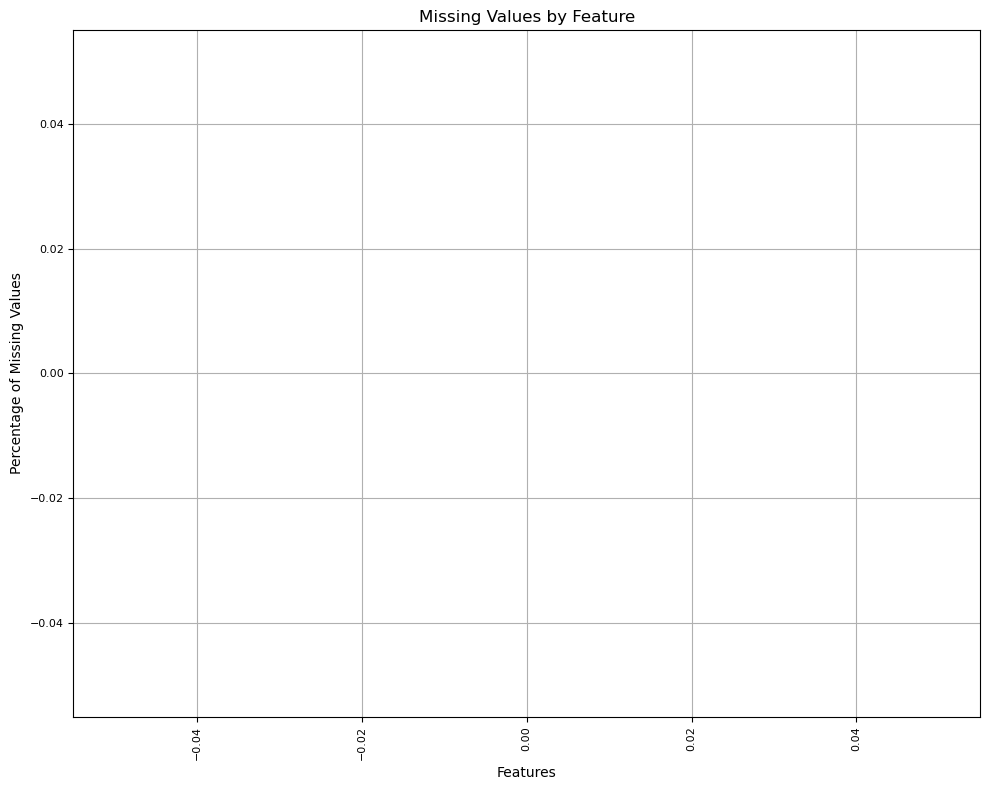

In [24]:
missing_values_table(df, plot=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34405 entries, 0 to 34404
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                34405 non-null  object 
 1   price               34405 non-null  float64
 2   area                34405 non-null  float64
 3   kitchen_area        34405 non-null  object 
 4   total_rooms         34405 non-null  float64
 5   floor               34405 non-null  float64
 6   total_floors        34405 non-null  float64
 7   build_date          34405 non-null  object 
 8   material_type       34405 non-null  object 
 9   remont              34405 non-null  object 
 10  total_balcony       34405 non-null  object 
 11  metro_name          34405 non-null  object 
 12  metro_dist_km       34405 non-null  float64
 13  distance_to_center  34405 non-null  float64
dtypes: float64(7), object(7)
memory usage: 3.7+ MB


# Visualization (graphics)

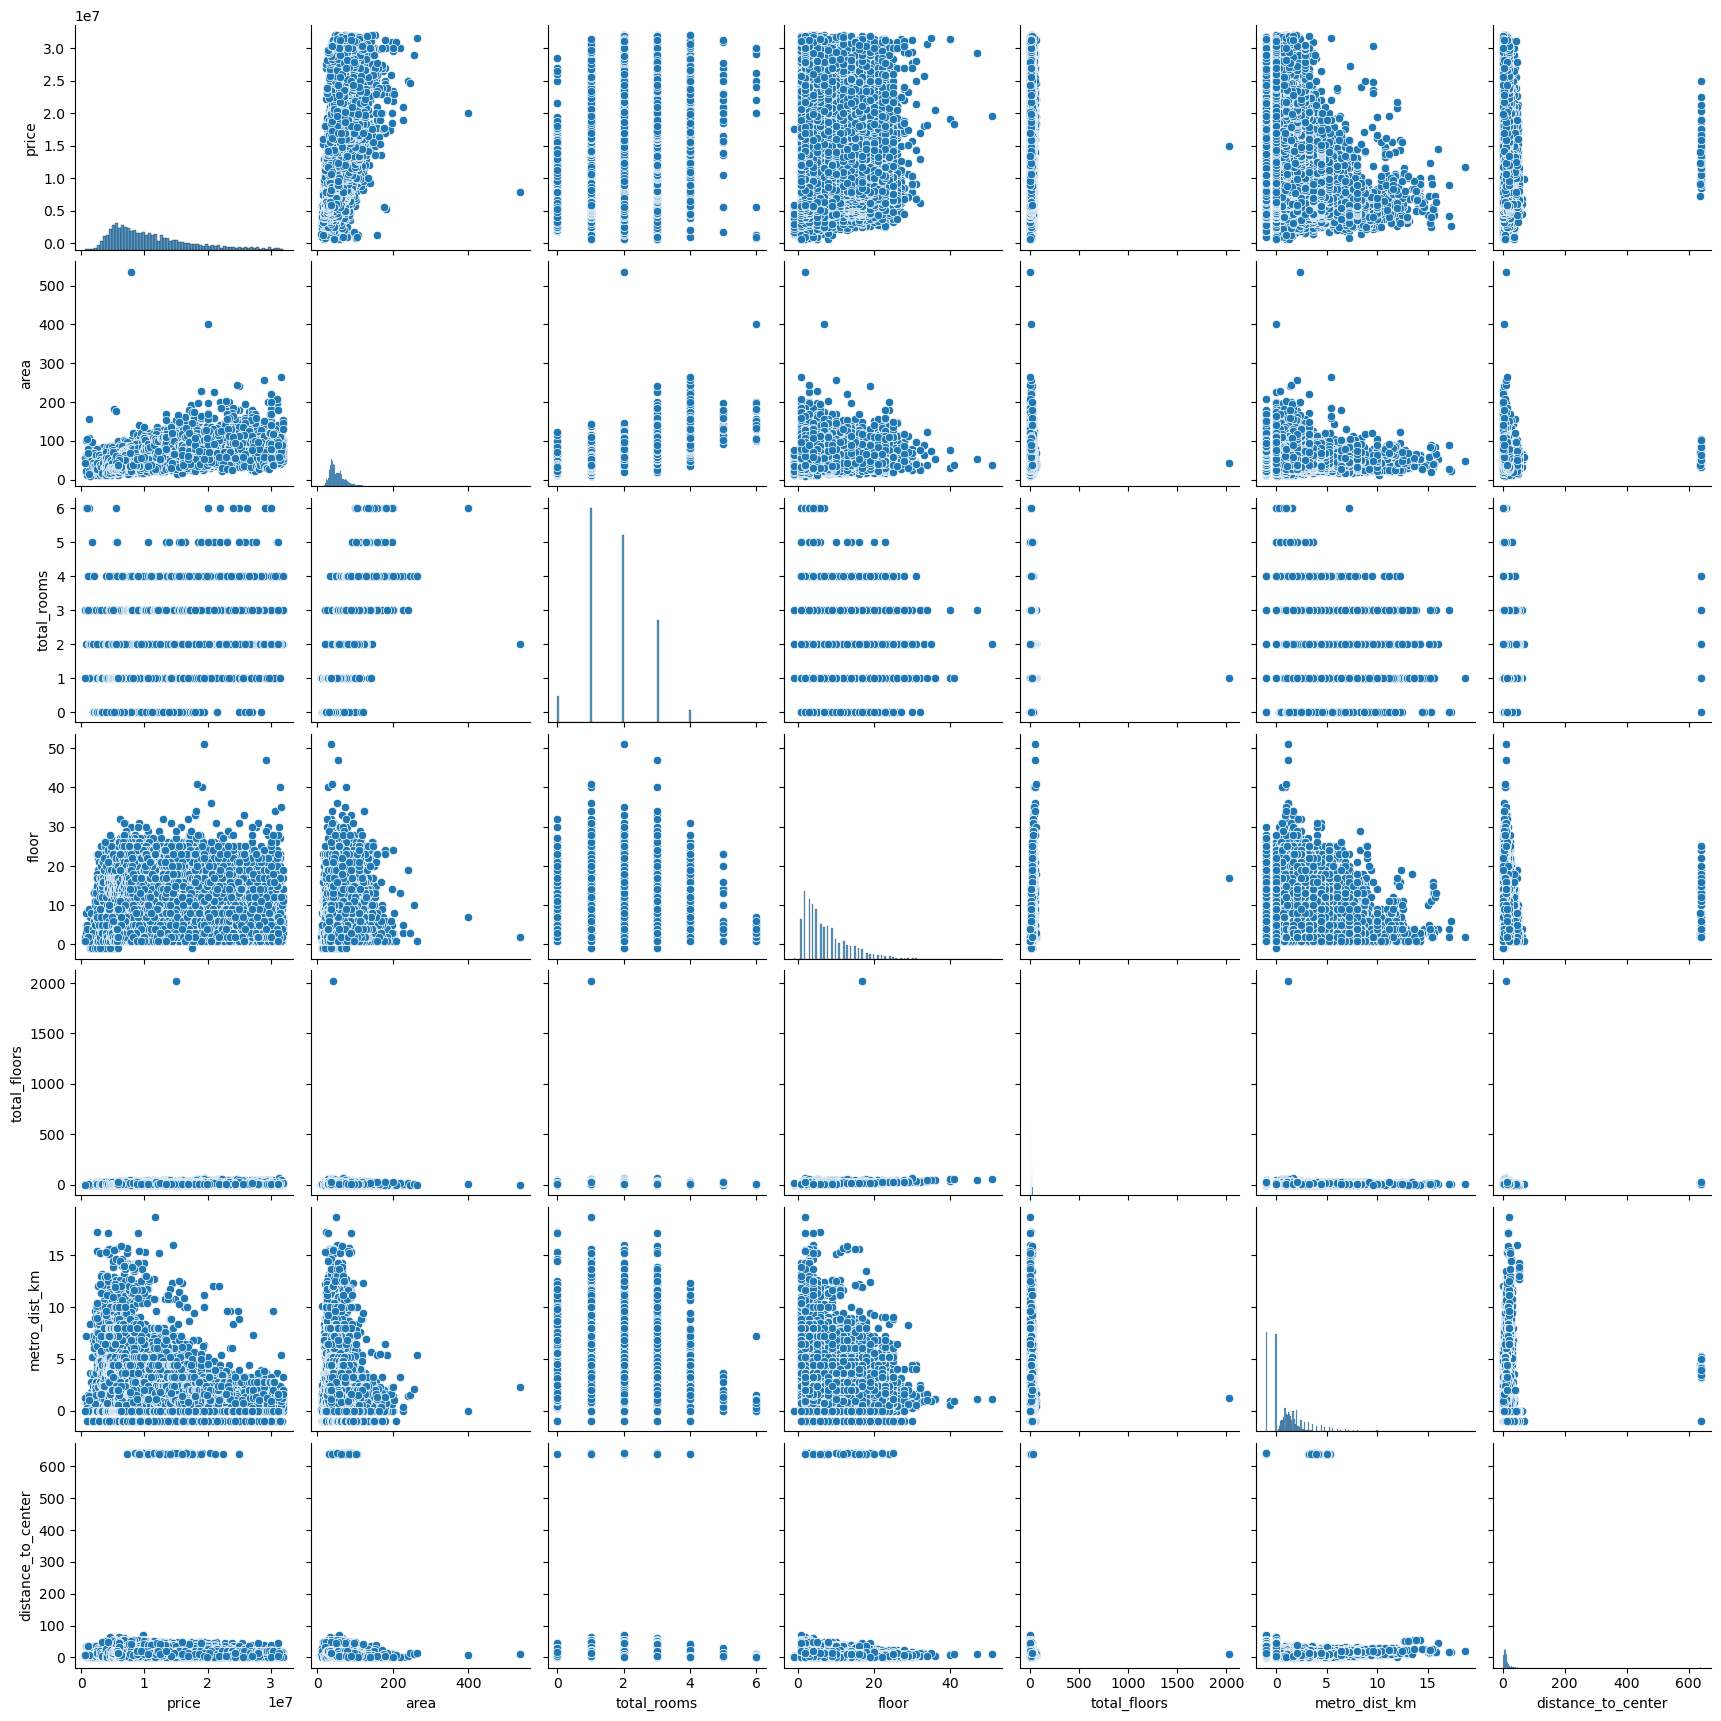

In [26]:
sns.pairplot(df)

In [27]:
count_rooms = df['total_rooms'].value_counts()
count_rooms

total_rooms
1.0    13568
2.0    11892
3.0     6478
0.0     1651
4.0      774
5.0       26
6.0       16
Name: count, dtype: int64

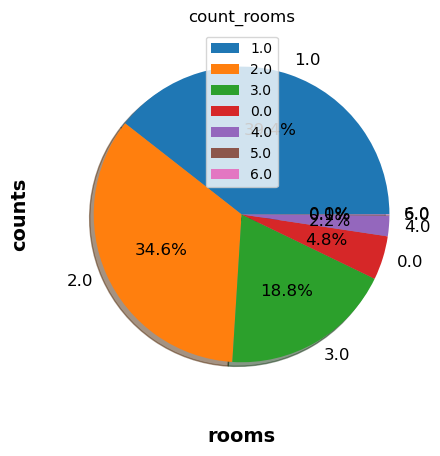

In [28]:
plt.figure()
explode = (0,0.09)
count_rooms.plot(kind = 'pie', fontsize = 12, autopct = '%.1f%%',shadow = True)
plt.title('count_rooms')
plt.xlabel('rooms', weight = "bold", color = "#000000", fontsize = 14, labelpad = 20)
plt.ylabel('counts', weight = "bold", color = "#000000", fontsize = 14, labelpad = 20)
plt.legend(labels = count_rooms.index, loc = "best")
plt.show()

In [29]:
count_city = df['city'].value_counts()
count_city

city
Санкт-Петербург    9360
Москва             7298
Новосибирск        3516
Екатеринбург       3156
Казань             2276
Геленджик          1457
Балашиха           1369
Самара             1288
Краснодар          1258
Нижний Новгород    1204
Анапа              1138
Сочи               1085
Name: count, dtype: int64

In [30]:
count_type_perec = df['material_type'].value_counts()
count_type_perec

material_type
Монолитный             11954
Панельный               8205
Кирпичный               7527
Монолитно-кирпичный     5533
Блочный                 1133
Деревянный                22
Старый фонд               22
Сталинский                 9
Name: count, dtype: int64

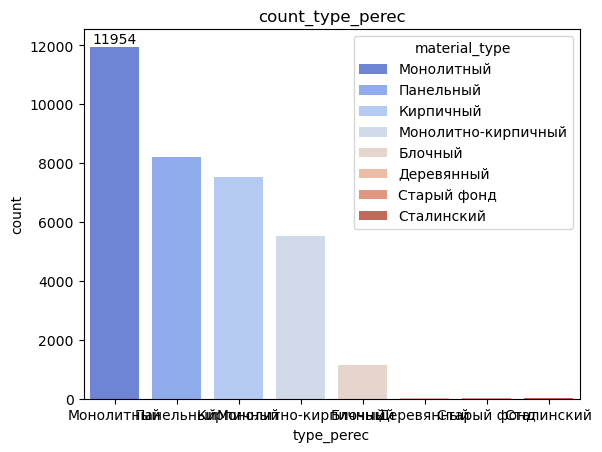

In [31]:
plt.figure()
ax = sns.barplot(x = count_type_perec.index,y = count_type_perec.values, palette='coolwarm', legend=True, hue=count_type_perec.index)
ax.bar_label(ax.containers[0], fontsize=10);
plt.title('count_type_perec')
plt.xlabel('type_perec')
plt.ylabel('count')
plt.show()

In [32]:
count_remont = df['remont'].value_counts()
count_remont

remont
empty             12278
standard           7242
well_done          6657
design             3072
without_repair     3059
fine                917
without             912
rough               232
simple               36
Name: count, dtype: int64

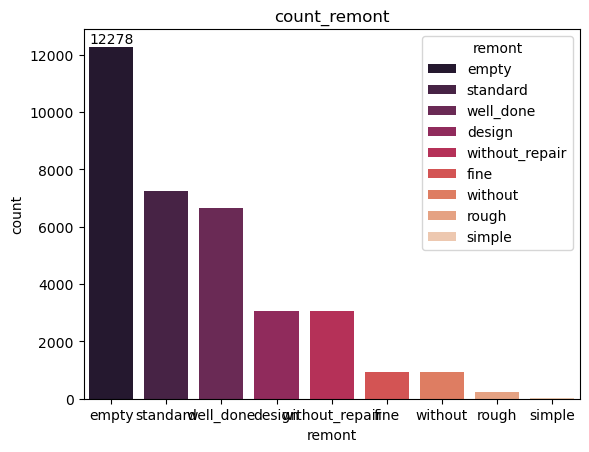

In [33]:
plt.figure()
ax = sns.barplot(x=count_remont.index,y=count_remont.values, palette='rocket', legend=True, hue=count_remont.index)
ax.bar_label(ax.containers[0], fontsize=10);
plt.title('count_remont')
plt.xlabel('remont')
plt.ylabel('count')
plt.show()

# Fix columns types :wrench:

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34405 entries, 0 to 34404
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                34405 non-null  object 
 1   price               34405 non-null  float64
 2   area                34405 non-null  float64
 3   kitchen_area        34405 non-null  object 
 4   total_rooms         34405 non-null  float64
 5   floor               34405 non-null  float64
 6   total_floors        34405 non-null  float64
 7   build_date          34405 non-null  object 
 8   material_type       34405 non-null  object 
 9   remont              34405 non-null  object 
 10  total_balcony       34405 non-null  object 
 11  metro_name          34405 non-null  object 
 12  metro_dist_km       34405 non-null  float64
 13  distance_to_center  34405 non-null  float64
dtypes: float64(7), object(7)
memory usage: 3.7+ MB


In [35]:
df.kitchen_area = df.kitchen_area.astype('float')
df.total_rooms = df.total_rooms.astype('float')
df.floor = df.floor.astype('int')
df.total_floors = df.total_floors.astype('int')
df.total_balcony = df.total_balcony.astype('float')
df.build_date = df.build_date.astype('float')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34405 entries, 0 to 34404
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                34405 non-null  object 
 1   price               34405 non-null  float64
 2   area                34405 non-null  float64
 3   kitchen_area        34405 non-null  float64
 4   total_rooms         34405 non-null  float64
 5   floor               34405 non-null  int64  
 6   total_floors        34405 non-null  int64  
 7   build_date          34405 non-null  float64
 8   material_type       34405 non-null  object 
 9   remont              34405 non-null  object 
 10  total_balcony       34405 non-null  float64
 11  metro_name          34405 non-null  object 
 12  metro_dist_km       34405 non-null  float64
 13  distance_to_center  34405 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 3.7+ MB


# :star: Features & Target :dart: 

In [37]:
x = df.drop(columns=['price'])
y = df['price']

In [38]:
y

0        10952600.0
1        16890000.0
2         9649380.0
3         8700000.0
4         2000000.0
            ...    
34400     5656320.0
34401     5721800.0
34402     5733750.0
34403     5782400.0
34404     5828800.0
Name: price, Length: 34405, dtype: float64

In [39]:
# y = y.values.reshape(-1,1)
# y

# :mag: Scaling and split :scissors:

In [40]:
# scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()
# x = scaler_x.fit_transform(x)
# y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test=train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)
# joblib.dump(scaler_x, "../../scalers/alpha1_x.bin")
# joblib.dump(scaler_y, "../../scalers/alpha1_y.bin")

In [41]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34405 entries, 0 to 34404
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                34405 non-null  object 
 1   area                34405 non-null  float64
 2   kitchen_area        34405 non-null  float64
 3   total_rooms         34405 non-null  float64
 4   floor               34405 non-null  int64  
 5   total_floors        34405 non-null  int64  
 6   build_date          34405 non-null  float64
 7   material_type       34405 non-null  object 
 8   remont              34405 non-null  object 
 9   total_balcony       34405 non-null  float64
 10  metro_name          34405 non-null  object 
 11  metro_dist_km       34405 non-null  float64
 12  distance_to_center  34405 non-null  float64
dtypes: float64(7), int64(2), object(4)
memory usage: 3.4+ MB


# Teach Models :books:

In [42]:
cb_learn_rate = 0.005
n_iterations = 30000
early_stop_rounds = 400

In [43]:
opt_catboost_params = {'iterations' : n_iterations,
                       'learning_rate' : cb_learn_rate,
                       'loss_function' : 'RMSE', 
                       'eval_metric' : 'RMSE',
                       'grow_policy' : 'SymmetricTree',
                       'verbose' : 500,
                       'random_seed' : 42,
                       'cat_features': [0, 7, 8, 10]}

model = CatBoostRegressor(**opt_catboost_params)
model.fit(X_train, y_train, eval_set=(X_val, y_val), 
           use_best_model=True, plot=True, 
           early_stopping_rounds=early_stop_rounds)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6180991.2190115	test: 6197749.0737667	best: 6197749.0737667 (0)	total: 65.9ms	remaining: 32m 56s
500:	learn: 2966044.0711700	test: 2949504.9606500	best: 2949504.9606500 (500)	total: 2.58s	remaining: 2m 31s
1000:	learn: 2578979.1901136	test: 2586596.9202916	best: 2586596.9202916 (1000)	total: 5.15s	remaining: 2m 29s
1500:	learn: 2427390.6772977	test: 2456024.2870247	best: 2456024.2870247 (1500)	total: 7.79s	remaining: 2m 27s
2000:	learn: 2336232.8421800	test: 2383534.4102413	best: 2383534.4102413 (2000)	total: 10.4s	remaining: 2m 25s
2500:	learn: 2268192.3291991	test: 2334145.6592847	best: 2334145.6592847 (2500)	total: 13.2s	remaining: 2m 24s
3000:	learn: 2216194.8864531	test: 2299574.8922946	best: 2299574.8922946 (3000)	total: 15.7s	remaining: 2m 21s
3500:	learn: 2172480.7099437	test: 2270831.5280710	best: 2270831.5280710 (3500)	total: 18.3s	remaining: 2m 18s
4000:	learn: 2136529.5917948	test: 2246471.2065617	best: 2246471.2065617 (4000)	total: 20.9s	remaining: 2m 15s
4500:	l

# Test model 

In [44]:
y_pred = model.predict(X_test)
    
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
    
print("Results for CatBoost:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score:", r2)
print()

Results for CatBoost:
Mean Squared Error (MSE): 3758280944596.2993
Root Mean Squared Error (RMSE): 1938628.6247232344
Mean Absolute Error (MAE): 1277731.2458280195
R-squared Score: 0.9031531471179164



# Features importances :star:

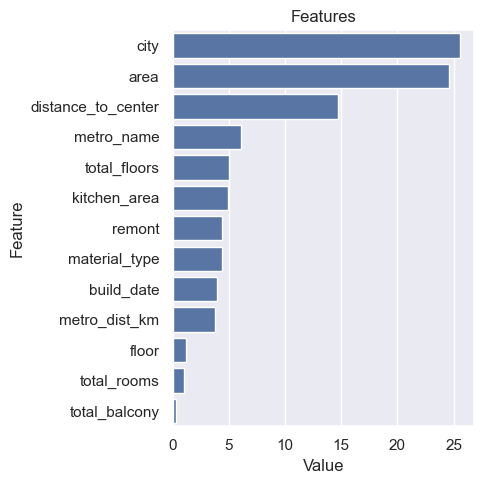

In [45]:
def plot_importance(model, features, dataframe, save=False):
    num = len(dataframe)
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(5, 5))
    sns.set_theme(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:40])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("../../img/importances.png")

plot_importance(model, X_train, df)

# Get model params

In [46]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 30000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Bor

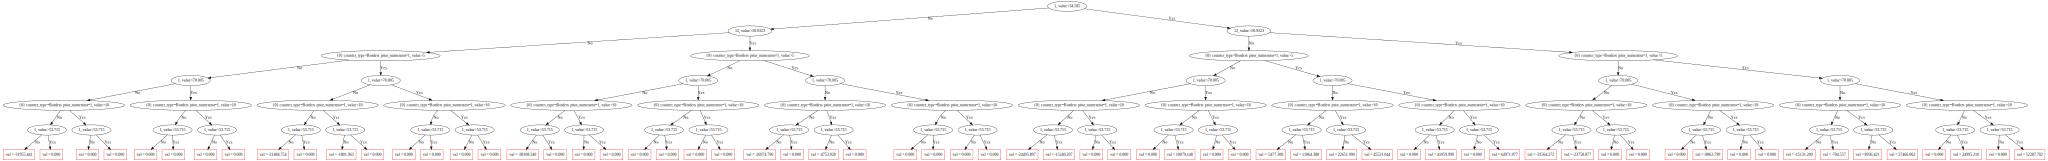

In [49]:
model.plot_tree(0)

# Save the best model :floppy_disk:

In [50]:
model_path = "../../models/kosogorova2.cbm"
model.save_model(model_path)


# Test the best model :triangular_ruler:

In [51]:
available_values = {
    'city': list(df.city.unique()),
    'material_type': list(df.material_type.unique()),
    'remont': list(df.remont.unique()),
    'metro_name': list(df.metro_name.unique())
}
with open('../../src/available_values.json', 'w') as f:
    json.dump(available_values, f)
available_values


{'city': ['Анапа',
  'Балашиха',
  'Екатеринбург',
  'Геленджик',
  'Казань',
  'Краснодар',
  'Москва',
  'Нижний Новгород',
  'Новосибирск',
  'Самара',
  'Сочи',
  'Санкт-Петербург'],
 'material_type': ['Монолитный',
  'Блочный',
  'Монолитно-кирпичный',
  'Панельный',
  'Кирпичный',
  'Деревянный',
  'Старый фонд',
  'Сталинский'],
 'remont': ['fine',
  'empty',
  'without',
  'rough',
  'standard',
  'design',
  'well_done',
  'without_repair',
  'simple'],
 'metro_name': ['',
  'Некрасовка',
  'Салтыковская',
  'Реутов',
  'Новокосино',
  'Железнодорожная',
  'Щёлковская',
  'Кучино',
  'Ольгино',
  'Никольское',
  'Новогиреево',
  'Первомайская',
  'Динамо',
  'Чкаловская',
  'Площадь 1905 года',
  'Машиностроителей',
  'Уралмаш',
  'Геологическая',
  'Ботаническая',
  'Уральская',
  'Проспект Космонавтов',
  'Аметьево',
  'Горки',
  'Суконная слобода',
  'Проспект Победы',
  'Площадь Тукая',
  'Северный Вокзал',
  'Козья слобода',
  'Авиастроительная',
  'Кремлёвская',
  'Яшьле

In [52]:
dict_param = ((df.drop(['price'], axis=1)).iloc[0]).to_dict()
dict_param

{'city': 'Анапа',
 'area': 46.0,
 'kitchen_area': 23.1,
 'total_rooms': 2.0,
 'floor': 6,
 'total_floors': 8,
 'build_date': 1997.9855079006772,
 'material_type': 'Монолитный',
 'remont': 'fine',
 'total_balcony': 1.0,
 'metro_name': '',
 'metro_dist_km': 0.0,
 'distance_to_center': 10.867409215055272}

In [53]:
model = CatBoostRegressor().load_model(model_path)


def price_predict(model, dict_param):
    df = pd.DataFrame.from_dict({'0': dict_param.values()}, columns=dict_param.keys(), orient='index')
    df = df[['city', 'area', 'kitchen_area', 'total_rooms', 'floor', 'total_floors',
       'build_date', 'material_type', 'remont', 'total_balcony', 'metro_name',
       'metro_dist_km', 'distance_to_center']]
    result = model.predict(df)
    return ceil(result)

In [54]:
price_predict(model, dict_param)

10585166